# **REQUIREMENTS**




In [1]:
pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.6 MB/s eta 0:00:00


In [2]:
pip install tabulate

# **IMPORTING**

In [3]:
import sqlite3
from faker import Faker
import random
from datetime import datetime, timedelta
from tabulate import tabulate

# **ERD**

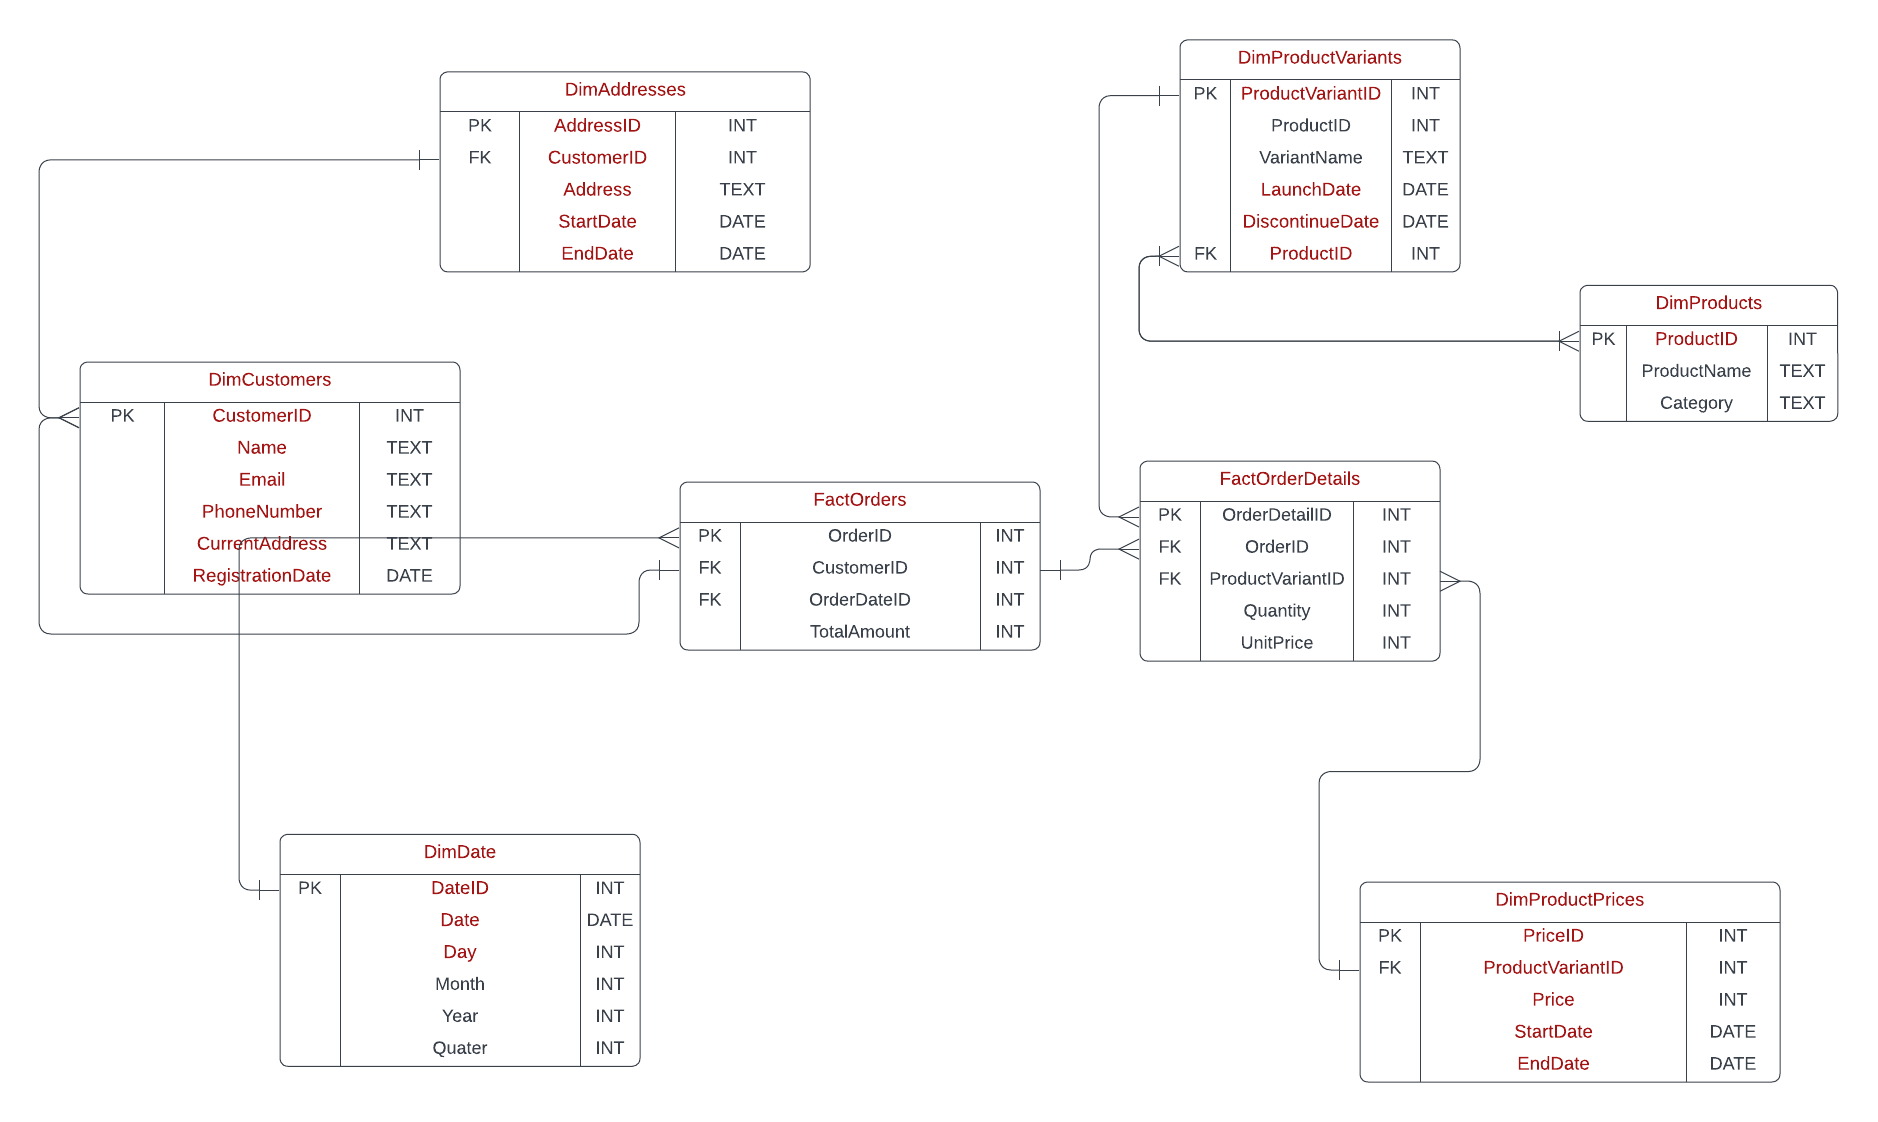

# **CONNECTING TO SQL DB**

In [4]:

# Initialize Faker
fake = Faker()

# Connect to SQLite database (or create it)
conn = sqlite3.connect('ecommerce_star.db')
cursor = conn.cursor()

# **CREATING TABLES**

In [5]:
###########################Creating tables---------------------------------
cursor.execute('''
CREATE TABLE IF NOT EXISTS DimCustomers (
    CustomerID INTEGER PRIMARY KEY,
    Name TEXT,
    Email TEXT,
    PhoneNumber TEXT,
    CurrentAddress TEXT,
    RegistrationDate DATE
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS DimAddresses (
    AddressID INTEGER PRIMARY KEY,
    CustomerID INTEGER,
    Address TEXT,
    StartDate DATE,
    EndDate DATE,
    FOREIGN KEY(CustomerID) REFERENCES DimCustomers(CustomerID)
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS DimProducts (
    ProductID INTEGER PRIMARY KEY,
    ProductName TEXT,
    Category TEXT
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS DimProductVariants (
    ProductVariantID INTEGER PRIMARY KEY,
    ProductID INTEGER,
    VariantName TEXT,
    LaunchDate DATE,
    DiscontinueDate DATE,
    FOREIGN KEY(ProductID) REFERENCES DimProducts(ProductID)
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS DimProductPrices (
    PriceID INTEGER PRIMARY KEY,
    ProductVariantID INTEGER,
    Price REAL,
    StartDate DATE,
    EndDate DATE,
    FOREIGN KEY(ProductVariantID) REFERENCES DimProductVariants(ProductVariantID)
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS DimDate (
    DateID INTEGER PRIMARY KEY,
    Date DATE,
    Day INTEGER,
    Month INTEGER,
    Year INTEGER,
    Quarter INTEGER
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS FactOrders (
    OrderID INTEGER PRIMARY KEY,
    CustomerID INTEGER,
    OrderDateID INTEGER,
    TotalAmount INTEGER,
    FOREIGN KEY(CustomerID) REFERENCES DimCustomers(CustomerID),
    FOREIGN KEY(OrderDateID) REFERENCES DimDate(DateID)
)''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS FactOrderDetails (
    OrderDetailID INTEGER PRIMARY KEY,
    OrderID INTEGER,
    ProductVariantID INTEGER,
    Quantity INTEGER,
    UnitPrice INTEGER,
    FOREIGN KEY(OrderID) REFERENCES FactOrders(OrderID),
    FOREIGN KEY(ProductVariantID) REFERENCES DimProductVariants(ProductVariantID)
)''')

# **GENERATING FAKE DATA USING FAKER LIBRARY**

In [6]:
# Generate sample data
def generate_customers(num):
    customers = []
    for _ in range(num):
        name = fake.name()
        email = fake.email()
        phone = fake.phone_number()
        address = fake.address()
        registration_date = fake.date_between(start_date='-3y', end_date='today')
        customers.append((name, email, phone, address, registration_date))
    return customers

def generate_addresses(customers):
    addresses = []
    for customer_id, customer in enumerate(customers, start=1):
        address = customer[3]
        start_date = customer[4]
        end_date = fake.date_between(start_date=start_date, end_date='today')
        addresses.append((customer_id, address, start_date, end_date))
        if random.choice([True, False]):
            address = fake.address()
            start_date = end_date + timedelta(days=1)
            end_date = None
            addresses.append((customer_id, address, start_date, end_date))
    return addresses

def generate_products(num):
    products = []
    for _ in range(num):
        product_name = fake.word().capitalize()
        category = fake.word().capitalize()
        products.append((product_name, category))
    return products

def generate_variants(products):
    variants = []
    for product_id, product in enumerate(products, start=1):
        num_variants = random.randint(1, 3)
        for _ in range(num_variants):
            variant_name = product[0] + " " + fake.word().capitalize()
            launch_date = fake.date_between(start_date='-3y', end_date='today')
            discontinue_date = fake.date_between(start_date=launch_date, end_date='today') if random.choice([True, False]) else None
            variants.append((product_id, variant_name, launch_date, discontinue_date))
    return variants

def generate_prices(variants):
    prices = []
    for variant_id, variant in enumerate(variants, start=1):
        price = round(random.uniform(10, 500), 2)
        start_date = variant[2]
        end_date = fake.date_between(start_date=start_date, end_date='today')
        prices.append((variant_id, price, start_date, end_date))
        if random.choice([True, False]):
            price = round(random.uniform(10, 500), 2)
            start_date = end_date + timedelta(days=1)
            end_date = None
            prices.append((variant_id, price, start_date, end_date))
    return prices

def generate_dates(start_date, end_date):
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append((current_date, current_date.day, current_date.month, current_date.year, (current_date.month - 1) // 3 + 1))
        current_date += timedelta(days=1)
    return dates

def generate_orders(customers, variants, date_ids):
    orders = []
    order_details = []
    for order_id in range(1, 201):
        customer_id = random.randint(1, len(customers))
        order_date_id = random.choice(date_ids)
        total_amount = 0
        num_items = random.randint(1, 5)
        for _ in range(num_items):
            variant_id = random.randint(1, len(variants))
            quantity = random.randint(1, 10)
            price = random.uniform(10, 500)
            total_amount += quantity * price
            order_details.append((order_id, variant_id, quantity, price))
        orders.append((customer_id, order_date_id, round(total_amount, 2)))
    return orders, order_details


# **INSERTING DATA INTO TABLES**

In [7]:
dates = generate_dates(datetime(2022, 1, 1), datetime(2024, 12, 31))
cursor.executemany('INSERT INTO DimDate (Date, Day, Month, Year, Quarter) VALUES (?, ?, ?, ?, ?)', dates)
date_ids = [i[0] for i in cursor.execute('SELECT DateID FROM DimDate').fetchall()]

customers = generate_customers(10)
cursor.executemany('INSERT INTO DimCustomers (Name, Email, PhoneNumber, CurrentAddress, RegistrationDate) VALUES (?, ?, ?, ?, ?)', customers)

addresses = generate_addresses(customers)
cursor.executemany('INSERT INTO DimAddresses (CustomerID, Address, StartDate, EndDate) VALUES (?, ?, ?, ?)', addresses)

products = generate_products(10)
cursor.executemany('INSERT INTO DimProducts (ProductName, Category) VALUES (?, ?)', products)

variants = generate_variants(products)
cursor.executemany('INSERT INTO DimProductVariants (ProductID, VariantName, LaunchDate, DiscontinueDate) VALUES (?, ?, ?, ?)', variants)

prices = generate_prices(variants)
cursor.executemany('INSERT INTO DimProductPrices (ProductVariantID, Price, StartDate, EndDate) VALUES (?, ?, ?, ?)', prices)

orders, order_details = generate_orders(customers, variants, date_ids)
cursor.executemany('INSERT INTO FactOrders (CustomerID, OrderDateID, TotalAmount) VALUES (?, ?, ?)', orders)
cursor.executemany('INSERT INTO FactOrderDetails (OrderID, ProductVariantID, Quantity, UnitPrice) VALUES (?, ?, ?, ?)', order_details)

# Commit and close
conn.commit()
conn.close()

In [8]:
conn = sqlite3.connect('ecommerce_star.db')
cursor = conn.cursor()

# **VIEWING ALL THE DATA IN TABLES**

In [9]:
print('DimCustomers')

cursor.execute('SELECT * FROM DimCustomers LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimCustomers
+--------------+------------------+---------------------------+----------------------+--------------------------------+--------------------+
|   CustomerID | Name             | Email                     | PhoneNumber          | CurrentAddress                 | RegistrationDate   |
+==============+==================+===========================+======================+================================+====================+
|            1 | Anna Walters     | tracey55@example.net      | (331)642-1909x69894  | 436 Middleton Shoals Suite 847 | 2022-07-30         |
|              |                  |                           |                      | Hernandezhaven, TN 28972       |                    |
+--------------+------------------+---------------------------+----------------------+--------------------------------+--------------------+
|            2 | Juan Acosta      | timothy52@example.org     | 892.668.2702x58969   | 381 Gary Manors                | 2024-04-18         |


In [10]:
print('DimAddresses')
cursor.execute('SELECT * FROM DimAddresses LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimAddresses
+-------------+--------------+-----------------------------------+-------------+------------+
|   AddressID |   CustomerID | Address                           | StartDate   | EndDate    |
+=============+==============+===================================+=============+============+
|           1 |            1 | 436 Middleton Shoals Suite 847    | 2022-07-30  | 2023-01-15 |
|             |              | Hernandezhaven, TN 28972          |             |            |
+-------------+--------------+-----------------------------------+-------------+------------+
|           2 |            1 | 24692 Victoria Motorway Suite 335 | 2023-01-16  |            |
|             |              | Anthonyborough, OR 14408          |             |            |
+-------------+--------------+-----------------------------------+-------------+------------+
|           3 |            2 | 381 Gary Manors                   | 2024-04-18  | 2024-05-25 |
|             |              | East Stephanie, 

In [11]:
print('DimCustomers')
cursor.execute('SELECT * FROM DimCustomers LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimCustomers
+--------------+------------------+---------------------------+----------------------+--------------------------------+--------------------+
|   CustomerID | Name             | Email                     | PhoneNumber          | CurrentAddress                 | RegistrationDate   |
+==============+==================+===========================+======================+================================+====================+
|            1 | Anna Walters     | tracey55@example.net      | (331)642-1909x69894  | 436 Middleton Shoals Suite 847 | 2022-07-30         |
|              |                  |                           |                      | Hernandezhaven, TN 28972       |                    |
+--------------+------------------+---------------------------+----------------------+--------------------------------+--------------------+
|            2 | Juan Acosta      | timothy52@example.org     | 892.668.2702x58969   | 381 Gary Manors                | 2024-04-18         |


In [12]:
print('DimProducts')
cursor.execute('SELECT * FROM DimProducts LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimProducts
+-------------+---------------+------------+
|   ProductID | ProductName   | Category   |
+=============+===============+============+
|           1 | Process       | Partner    |
+-------------+---------------+------------+
|           2 | Traditional   | Seem       |
+-------------+---------------+------------+
|           3 | Attention     | Too        |
+-------------+---------------+------------+
|           4 | Human         | Policy     |
+-------------+---------------+------------+
|           5 | Director      | Successful |
+-------------+---------------+------------+
|           6 | According     | Entire     |
+-------------+---------------+------------+
|           7 | Ok            | Hand       |
+-------------+---------------+------------+
|           8 | They          | Site       |
+-------------+---------------+------------+
|           9 | Story         | Inside     |
+-------------+---------------+------------+
|          10 | All           | Alone      

In [13]:
print('DimProductVariants')
cursor.execute('SELECT * FROM DimProductVariants LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimProductVariants
+--------------------+-------------+-----------------------+--------------+-------------------+
|   ProductVariantID |   ProductID | VariantName           | LaunchDate   | DiscontinueDate   |
+====================+=============+=======================+==============+===================+
|                  1 |           1 | Process Finish        | 2022-07-06   | 2023-07-10        |
+--------------------+-------------+-----------------------+--------------+-------------------+
|                  2 |           1 | Process Understand    | 2023-01-30   | 2024-04-01        |
+--------------------+-------------+-----------------------+--------------+-------------------+
|                  3 |           2 | Traditional Attention | 2023-01-24   | 2024-02-11        |
+--------------------+-------------+-----------------------+--------------+-------------------+
|                  4 |           2 | Traditional Style     | 2022-06-09   | 2023-08-25        |
+--------------------

In [14]:
print('DimProductPrices')
cursor.execute('SELECT * FROM DimProductPrices LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimProductPrices
+-----------+--------------------+---------+-------------+------------+
|   PriceID |   ProductVariantID |   Price | StartDate   | EndDate    |
+===========+====================+=========+=============+============+
|         1 |                  1 |  156.65 | 2022-07-06  | 2022-11-22 |
+-----------+--------------------+---------+-------------+------------+
|         2 |                  2 |  156.62 | 2023-01-30  | 2023-12-12 |
+-----------+--------------------+---------+-------------+------------+
|         3 |                  3 |  224.46 | 2023-01-24  | 2023-11-15 |
+-----------+--------------------+---------+-------------+------------+
|         4 |                  3 |  341.91 | 2023-11-16  |            |
+-----------+--------------------+---------+-------------+------------+
|         5 |                  4 |  448.66 | 2022-06-09  | 2023-06-23 |
+-----------+--------------------+---------+-------------+------------+
|         6 |                  5 |  467.68 | 20

In [15]:
print('DimDate')
cursor.execute('SELECT * FROM DimDate LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

DimDate
+----------+---------------------+-------+---------+--------+-----------+
|   DateID | Date                |   Day |   Month |   Year |   Quarter |
+==========+=====================+=======+=========+========+===========+
|        1 | 2022-01-01 00:00:00 |     1 |       1 |   2022 |         1 |
+----------+---------------------+-------+---------+--------+-----------+
|        2 | 2022-01-02 00:00:00 |     2 |       1 |   2022 |         1 |
+----------+---------------------+-------+---------+--------+-----------+
|        3 | 2022-01-03 00:00:00 |     3 |       1 |   2022 |         1 |
+----------+---------------------+-------+---------+--------+-----------+
|        4 | 2022-01-04 00:00:00 |     4 |       1 |   2022 |         1 |
+----------+---------------------+-------+---------+--------+-----------+
|        5 | 2022-01-05 00:00:00 |     5 |       1 |   2022 |         1 |
+----------+---------------------+-------+---------+--------+-----------+
|        6 | 2022-01-06 00:00:

In [16]:
print('FactOrders')
cursor.execute('SELECT * FROM FactOrders LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

FactOrders
+-----------+--------------+---------------+---------------+
|   OrderID |   CustomerID |   OrderDateID |   TotalAmount |
+===========+==============+===============+===============+
|         1 |            1 |           706 |       3252.46 |
+-----------+--------------+---------------+---------------+
|         2 |            1 |           441 |       5222.66 |
+-----------+--------------+---------------+---------------+
|         3 |            2 |            81 |        175.86 |
+-----------+--------------+---------------+---------------+
|         4 |            5 |            88 |       7191.59 |
+-----------+--------------+---------------+---------------+
|         5 |            7 |           659 |       1476.51 |
+-----------+--------------+---------------+---------------+
|         6 |            4 |           553 |      10173.8  |
+-----------+--------------+---------------+---------------+
|         7 |            8 |           569 |       6648.01 |
+-----------+

In [17]:
print('FactOrderDetails')
cursor.execute('SELECT * FROM FactOrderDetails LIMIT 10')
rows = cursor.fetchall()
headers = [description[0] for description in cursor.description]
print(tabulate(rows[:10], headers=headers, tablefmt="grid"))

FactOrderDetails
+-----------------+-----------+--------------------+------------+-------------+
|   OrderDetailID |   OrderID |   ProductVariantID |   Quantity |   UnitPrice |
+=================+===========+====================+============+=============+
|               1 |         1 |                 15 |          2 |    414.742  |
+-----------------+-----------+--------------------+------------+-------------+
|               2 |         1 |                  4 |          7 |    333.789  |
+-----------------+-----------+--------------------+------------+-------------+
|               3 |         1 |                  3 |          6 |     14.409  |
+-----------------+-----------+--------------------+------------+-------------+
|               4 |         2 |                 13 |          8 |    350.29   |
+-----------------+-----------+--------------------+------------+-------------+
|               5 |         2 |                 13 |          4 |    267.57   |
+-----------------+----

In [18]:
conn.close()